# Example preprocessing notebook

In this notebook we are going to walk through a single patient example. There are probably some patient-specific stuff in here that might change with other patients. Should be able to demonstrate the usage of different functions from the toolbox.

1. Load raw data (.edf in this notebook) using mne

2. Add in electrode information

3. Notch filter line noise and cleaning out bad channels 

4. Re-reference the data 

5. Annotate data (i.e. artifact and IEDs) 


Must read guides: 

https://www.sciencedirect.com/science/article/pii/S1053811922005559


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
from mne.preprocessing.bads import _find_outliers

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils

## Load raw data (.edf in this notebook) using mne

It's a good idea to setup a sensible directory structure like below. Note that all my data lives on '/sc/arion' which is Minerva. 


mne: https://mne.tools/stable/index.html

In [5]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results 

save_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/MS007'  # save intermediate results in the 'work' directory
    
# I have saved most of my raw data in the 'projects directory'
behav_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/behav/Day1'
neural_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/neural/Day1'
anat_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/anat'
edf_files = glob(f'{neural_dir}/*.edf')




Try loading in the data into memory

In [6]:
MS007_data = mne.io.read_raw_edf(edf_files[0], preload=True)
# If you try to preload, it will kill the kernel (at mem=4000). Probably need to request more memory in Minerva (mem=8000 seems to work)

# # If not preloading: 
# raw_data = MS007_data.get_data()

Extracting EDF parameters from /sc/arion/projects/guLab/Salman/EMU/MS007/neural/Day1/MS007_MemBandit.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1867007  =      0.000 ...  1823.249 secs...


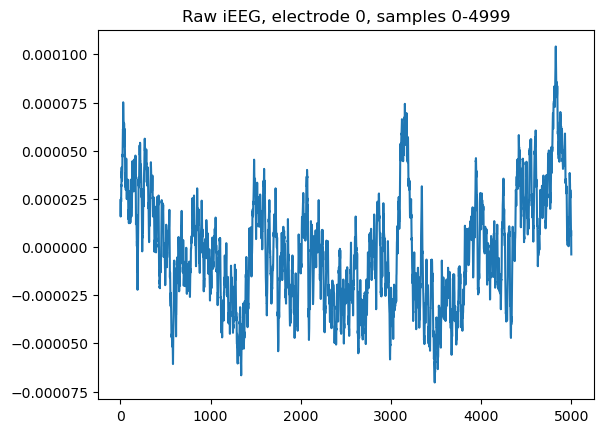

In [7]:
# Sanity check
plt.plot(MS007_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

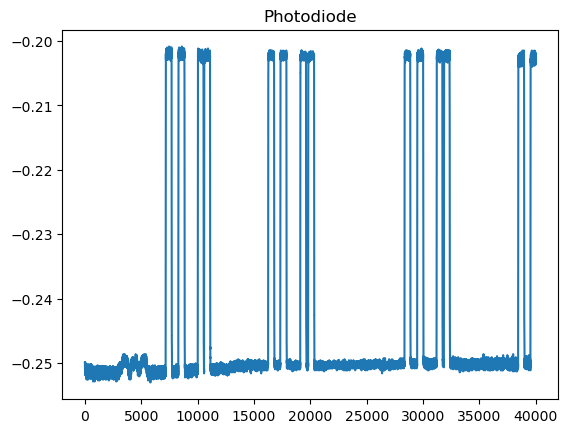

In [8]:
# Sanity check the photodiode
trig_ix = MS007_data.ch_names.index('DC1')
plt.plot(MS007_data._data[trig_ix, 10000:50000])
plt.title("Photodiode")
plt.show()

## Add in electrode information

In [9]:
# Load the electrode localization data and add it in

csv_files = glob(f'{anat_dir}/*labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

# # identify the bundles for re-referencing:
# loc_data['bundle'] = np.nan
# loc_data['bundle'] = loc_data.apply(lambda x: ''.join(i for i in x.label if not i.isdigit()), axis=1)



In [10]:
elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A13_L,-6.549650,41.776780,-7.03872,-6.149690,34.97941,-12.45010,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L OrG,Left frontal pole 1 C,NaN,NaN
1,LaCaS10,A9l_L,-9.746730,49.772330,37.28761,-11.158100,45.87980,38.08775,Gray,Left Cerebral White Matter,Unknown,L Superior Frontal Gyrus,L SFG,Unknown,Left superior frontal gyrus 2 C,NaN
2,LaCaS11,A9l_L,-9.746730,50.971670,42.07965,-11.033800,47.45796,43.55471,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,WM,NaN
3,LaCaS12,A9l_L,-10.146400,50.971670,46.87168,-11.521400,47.74693,49.07517,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 3 C,NaN,NaN
4,LaCaS2,A32sg_L,-6.949280,42.576330,-2.24668,-6.826220,36.24643,-7.12713,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,RpCiP8,A39rd_R,32.614580,-40.977200,38.48562,34.704870,-57.38460,39.36843,White,Right Cerebral White Matter,Unknown,R Angular Gyrus,R IPL,Right supramarginal gyrus 4 A,WM,NaN
196,RpCiP9,A39rd_R,37.010560,-42.976100,40.48230,39.443400,-59.42050,41.61339,Gray,Right AnG angular gyrus,Unknown,R Angular Gyrus,R IPL,Right supramarginal gyrus 5 B,NaN,NaN
197,uLmOlF,A11l_L,-14.142700,46.174330,-15.82410,-14.133400,39.07736,-22.87590,White,Left MOrG medial orbital gyrus,Area Fo1,L Superior Orbital Gyrus,L OrG,Left frontal orbital 3 B,WM,NaN
198,uRHplT,rHipp_R,10.634660,4.597446,-17.82080,13.547580,-8.16845,-23.89940,Gray,Right PHG parahippocampal gyrus,Subiculum,Unknown,R Hipp,Right parahippocampal gyrus C,NaN,NaN


The electrode names read out of the edf file do not always match those 
in the pdf (used for localization). This could be error on the side of the tech who input the labels, 
or on the side of MNE reading the labels in. Usually there's a mixup between lowercase 'l' and capital 'I'.

Sometimes, there's electrodes on the pdf that are NOT in the MNE data structure... let's identify those as well. 


In [9]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(MS007_data.ch_names, elec_locs.label)




Could not find a match for rhplt9.


So we retun a new list of channel names for the mne data structure as well as a list of channels in the localization csv which are not found in the mne structure. Make sure that unmatched_seeg does not factor into any referencing schemes later - it's not in the MNE data

In [10]:
# Rename the mne data according to the localization data
new_name_dict = {x:y for (x,y) in zip(MS007_data.ch_names, new_mne_names)}
MS007_data.rename_channels(new_name_dict)

<RawEDF | MS007_MemBandit.edf, 276 x 1867008 (1823.2 s), ~3.84 GB, data loaded>

In [38]:
unmatched_seeg

['rhplt9']

In [12]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in MS007_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data.ch_names if i.startswith('l')]
# This is optional. I might want to look at scalp EEG at some point (lol) so might as well tag them here. 
eeg_names = [
 'fp1',
 'f7',
 't3',
 't5',
 'o1',
 'f3',
 'c3',
 'p3',
 'fp2',
 'f8',
 't4',
 't6',
 'o2',
 'f4',
 'c4',
 'p4',
 'fz',
 'cz',
 'pz']
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')
print(f'We have a total of {len(eeg_names)} EEG electrodes')
# MS007_data.set_channel_types()

We have a total of 196 sEEG electrodes
We have a total of 19 EEG electrodes


In [13]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
EEG_mapping_dict = {f'{x}':'eeg' for x in eeg_names}
trig_mapping_dict = {'dc1':'stim'}
# Drop random chans? 
drop_chans = list(set(MS007_data.ch_names)^set(eeg_names+left_seeg_names+right_seeg_names+['dc1']))
MS007_data.drop_channels(drop_chans)

<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [14]:
# Set channel types:
MS007_data.set_channel_types(sEEG_mapping_dict)
MS007_data.set_channel_types(EEG_mapping_dict)
MS007_data.set_channel_types(trig_mapping_dict)

/tmp/ipykernel_182879/1830004009.py:4: RuntimeWarning: The unit for channel(s) dc1 has changed from V to NA.
  MS007_data.set_channel_types(trig_mapping_dict)


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [15]:
# make montage (convert mm to m)!! I'm not sure if we will ever use or need this step, but why not just do it

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

MS007_data.set_montage(montage, match_case=False, on_missing='warn')


/tmp/ipykernel_182879/3983129385.py:7: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')
/tmp/ipykernel_182879/3983129385.py:7: RuntimeWarning: DigMontage is only a subset of info. There are 19 channel positions not present in the DigMontage. The required channels are:

['fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

## Notch filter line noise and cleaning out bad channels 


We want to remove the line noise (60 Hz and harmonics in US data, 50 Hz and harmonics in EU data). 

To do so, we use a band-stop filter that removes a narrow band of frequencies. 

Maybe eventually we don't want to use filters, especially if interested in ERPs: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6456018/

In [16]:
# Identify line noise
MS007_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
MS007_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:   13.5s finished


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [17]:
# Save out the photodiode channel separately
MS007_data.save(f'{save_dir}/photodiode.fif', picks='dc1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif
Closing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif
[done]


/tmp/ipykernel_182879/2725322655.py:2: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  MS007_data.save(f'{save_dir}/photodiode.fif', picks='dc1', overwrite=True)


Denote bad channels

In [18]:
# Clean up the MNE data 

bads = lfp_preprocess_utils.detect_bad_elecs(MS007_data, 
                                             sEEG_mapping_dict)

MS007_data.info['bads'] = bads

In [19]:
bads

['laglt10',
 'laglt8',
 'laglt9',
 'lcmfo7',
 'lhplt1',
 'lhplt2',
 'lmcms1',
 'lmcms2',
 'lmcms9',
 'lmolf4',
 'lmolf5',
 'racas8',
 'rpcip7']

In [20]:
# Let's pick out any bad channels missed by automatic screening, or restore channels that were erroneously deemed bad

When we plot the data using the interactive plotting, bad channels are grayed out. Can click them on the left to toggle this. We aren't annotating bad data time-windows yet! 

<IPython.core.display.Javascript object>


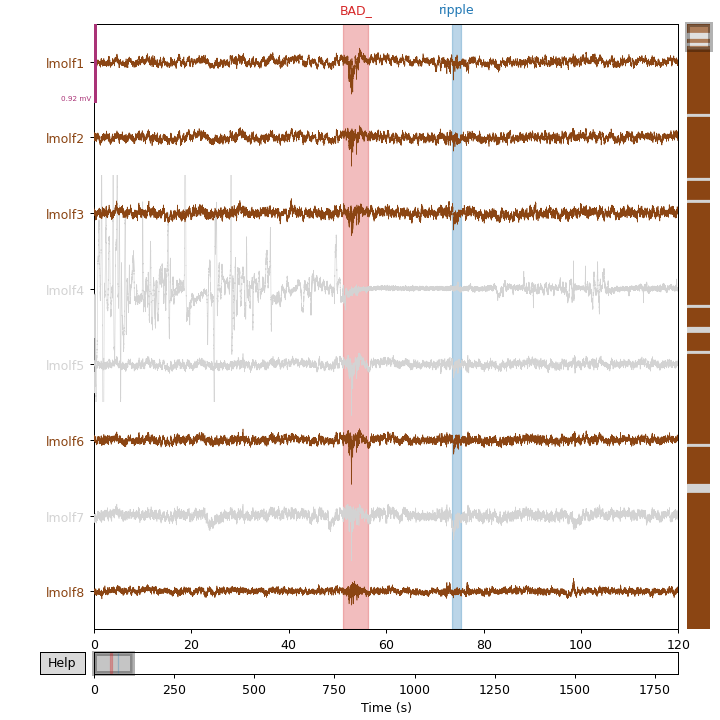

<IPython.core.display.Javascript object>


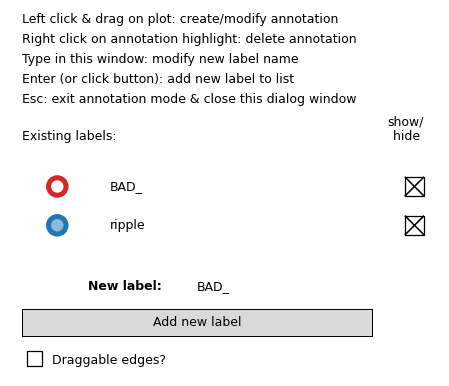

In [37]:
%matplotlib notebook
fig = MS007_data.plot(start=0, duration=120, n_channels=8, scalings=MS007_data._data.max()/20)
fig.fake_keypress('a')

Compare your revised list of 'bad' electrodes to thoe originally detected above.

In [22]:
MS007_data.info['bads']

['laglt10',
 'laglt8',
 'laglt9',
 'lcmfo7',
 'lmcms1',
 'lmcms2',
 'lmcms9',
 'lmolf4',
 'lmolf5',
 'racas8',
 'rpcip7',
 'laimm12',
 'lcmfo14',
 'lmolf7']

## Re-reference the data

If you're like me, you find the concept of re-referencing somewhat confusing. Isn't the data recorded relative to a ground and reference in the EMU (https://ahleighton.github.io/OE-ephys-course/EEA/theoryday3.html)? 

It is, but we do digital re-referencing of the recorded signal to clean up any remaining shared noise. 

**Re-referencing should be an EXTREMELY conscious choice as it changes the LFP signal dramatically!** In our case, we choose to do local white-matter re-referencing because electrodes in white matter should be fairly stable (low-variance) and not contain local, slow oscillations of interest. 

Now, let's use the localization data to determine the gray vs. white matter electrodes. 
Then, let's re-reference each gray matter electrode to the closest and most low-amplitude white matter electrode. 

Make sure 'bad' electrodes are not used in the re-referencing. Same with unmatched seeg electrodes (not present in the mne data structure).

In [23]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=MS007_data, 
                                                                                       loc_data=elec_locs, 
                                                                                       bad_channels=MS007_data.info['bads'], 
                                                                                       unmatched_seeg=unmatched_seeg,
                                                                                       site='MSSM')



In [25]:
cathode_list

['lmolf1',
 'lacas9',
 'lacas9',
 'lmolf1',
 'lmolf1',
 'lacas8',
 'lacas8',
 'lacas8',
 'lacas8',
 'lhplt5',
 'laglt6',
 'lhplt5',
 'lhplt5',
 'lhplt6',
 'laglt6',
 'laglt6',
 'laglt5',
 'laimm11',
 'laimm11',
 'laimm6',
 'lmolf6',
 'laimm8',
 'laimm6',
 'laimm8',
 'lcmfo4',
 'lcmfo10',
 'lcmfo10',
 'lcmfo4',
 'lcmfo4',
 'lcmfo6',
 'lcmfo6',
 'laglt5',
 'lhplt8',
 'laglt5',
 'laglt4',
 'lhplt6',
 'lhplt8',
 'lmcms5',
 'lmcms5',
 'lmcms5',
 'lmcms5',
 'lmcms8',
 'lmolf6',
 'laimm6',
 'laimm6',
 'laimm6',
 'lmolf1',
 'laimm8',
 'lhplt5',
 'lhplt5',
 'lhplt5',
 'lhplt5',
 'lhplt7',
 'lhplt8',
 'lhplt8',
 'lhplt8',
 'lpcip4',
 'lpcip10',
 'lpcip5',
 'rmolf4',
 'racas10',
 'rmolf4',
 'racas6',
 'racas5',
 'racas10',
 'raglt4',
 'raglt4',
 'raglt4',
 'raglt5',
 'raglt8',
 'rhplt8',
 'raglt5',
 'racas12',
 'racas12',
 'raimm5',
 'rmolf8',
 'rmolf8',
 'rmolf8',
 'racas9',
 'racas10',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',
 'raimm5',
 'raimm5',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',
 'rcmfo5',


In [26]:
MS007_data_reref = mne.set_bipolar_reference(MS007_data, 
                          anode=anode_list, 
                          cathode=cathode_list,
                          copy=True)

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=116, n_times=1867008
    Range : 0 ... 1867007 =      0.000 ...  1823.249 secs
Ready.
Added the following bipolar channels:
lacas1-lmolf1, lacas10-lacas9, lacas12-lacas9, lacas2-lmolf1, lacas3-lmolf1, lacas4-lacas8, lacas5-lacas8, lacas6-lacas8, lacas7-lacas8, laglt1-lhplt5, laglt10-laglt6, laglt2-lhplt5, laglt3-lhplt5, laglt7-lhplt6, laglt8-laglt6, laglt9-laglt6, laimm1-laglt5, laimm12-laimm11, laimm13-laimm11, laimm2-laimm6, laimm3-lmolf6, laimm4-laimm8, laimm5-laimm6, laimm7-laimm8, lcmfo1-lcmfo4, lcmfo12-lcmfo10, lcmfo13-lcmfo10, lcmfo2-lcmfo4, lcmfo3-lcmfo4, lcmfo7-lcmfo6, lcmfo8-lcmfo6, lhplt1-laglt5, lhplt10-lhplt8, lhplt2-laglt5, lhplt3-laglt4, lhplt4-lhplt6, lhplt9-lhplt8, lmcms1-lmcms5, lmcms2-lmcms5, lmcms3-lmcms5, lmcms4-lmcms5, lmcms9-lmcms8, lmolf2-lmolf6, lmolf3-laimm6, lmolf4-laimm6, lmolf5-laimm6, lmolf7-lmolf1, lmolf8-laimm8, lmtpt1-lhplt5, lmtpt2-lhplt5, lmtpt3-lhplt5, lmtpt

In [27]:
MS007_data_reref.drop_channels(drop_wm_channels)

<RawEDF | MS007_MemBandit.edf, 127 x 1867008 (1823.2 s), ~1.77 GB, data loaded>

In [28]:
drop_wm_channels

['lacas11',
 'laimm10',
 'laimm9',
 'lcmfo11',
 'lcmfo5',
 'lcmfo9',
 'lmcms6',
 'lmcms7',
 'lpcip3',
 'lpcip6',
 'lpcip7',
 'lpcip8',
 'lpcip9',
 'raimm10',
 'raimm9',
 'rcmfo6',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rmtpt5',
 'rpcip10',
 'rpcip3',
 'rpcip4']

In [29]:
MS007_data_reref.drop_channels(oob_channels)

<RawEDF | MS007_MemBandit.edf, 116 x 1867008 (1823.2 s), ~1.61 GB, data loaded>

In [30]:
right_seeg_names = [i for i in MS007_data_reref.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data_reref.ch_names if i.startswith('l')]
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
MS007_data_reref.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS007_MemBandit.edf, 116 x 1867008 (1823.2 s), ~1.61 GB, data loaded>

## Annotate data? Optional

In [31]:
# We COULD annotate the bad timepoints post-referencing. However, my personal preference is to do so after EPOCHING so I am not sending 
# too much subjective stuff to all my downstream analyses... 

# Furthermore, we only filter after epoching which definitely helps visualize bad epochs 



In [36]:
%matplotlib notebook
fig = MS007_data_reref.plot(start=0, duration=120, n_channels=8, scalings=MS007_data._data.max()/20)
# fig.fake_keypress('a')

Channels marked as bad:
['laglt10', 'laglt8', 'laglt9', 'lcmfo7', 'lmcms1', 'lmcms2', 'lmcms9', 'lmolf4', 'lmolf5', 'racas8', 'rpcip7', 'laimm12', 'lcmfo14', 'lmolf7']


ValueError: list.remove(x): x not in list

In [33]:
# Save out the re-referenced data:

MS007_data_reref.save(f'{save_dir}/wm_ref_ieeg.fif', overwrite=True)


Overwriting existing file.
Writing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/wm_ref_ieeg.fif
Closing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/wm_ref_ieeg.fif
[done]
